<a href="https://colab.research.google.com/github/Farah-Saleem91/adult-income-analysis/blob/main/adult_income_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
path='/content/drive/MyDrive/adult.csv'

In [131]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor # Import RandomForestRegressor
# Set pandas as the default output for sklearn
from sklearn import set_config
from sklearn.linear_model import LinearRegression
set_config(transform_output='pandas')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [132]:


df = pd.read_csv(path)


df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB



#Data Cleaning

In [134]:
#find duplicates
df.duplicated().sum()

np.int64(52)

In [135]:
#drop duplicates
df=df.drop_duplicates()
#drop fnlwgt
df=df.drop(columns=['fnlwgt'])


In [136]:
#conver ? values into missing in df2
df=df.replace('?',np.nan)

In [137]:
#find null values
df.isna().sum()

,0
age,0
workclass,2795
education,0
educational-num,0
marital-status,0
occupation,2805
relationship,0
race,0
gender,0
capital-gain,0


#EDA functions

In [138]:
"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


# TO DO: add the new print statements from explore_categorical
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


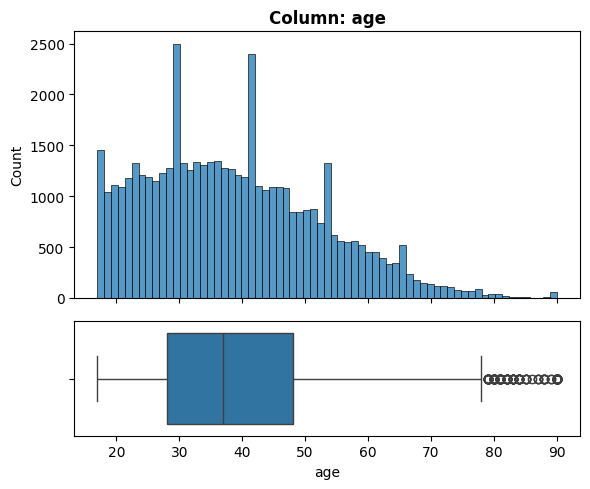

- NaN's Found: 0 (0.0%)
- Unique Values: 74
- Most common value: '36' occurs 1348 times (2.76%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: age'}, xlabel='age', ylabel='Count'>,
        <Axes: xlabel='age'>], dtype=object))

In [139]:
feature='age'
explore_numeric(df,feature)

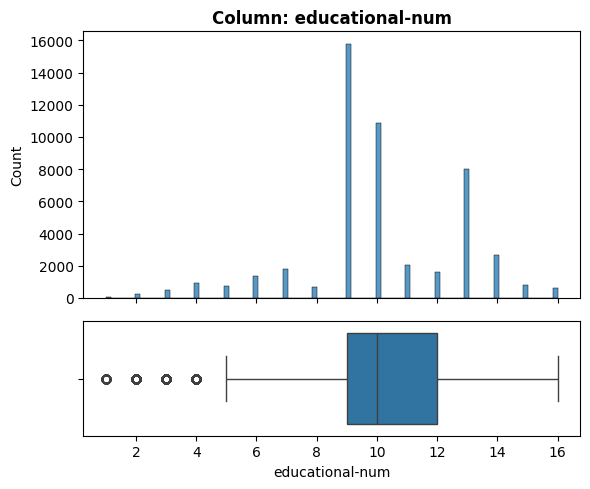

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: '9' occurs 15770 times (32.32%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: educational-num'}, xlabel='educational-num', ylabel='Count'>,
        <Axes: xlabel='educational-num'>], dtype=object))

In [140]:
feature='educational-num'
explore_numeric(df,feature)

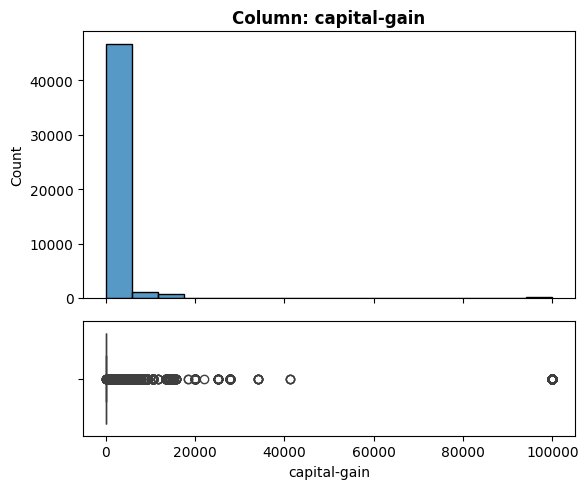

- NaN's Found: 0 (0.0%)
- Unique Values: 123
- Most common value: '0' occurs 44755 times (91.73%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: capital-gain'}, xlabel='capital-gain', ylabel='Count'>,
        <Axes: xlabel='capital-gain'>], dtype=object))

In [141]:
feature='capital-gain'
explore_numeric(df,feature)

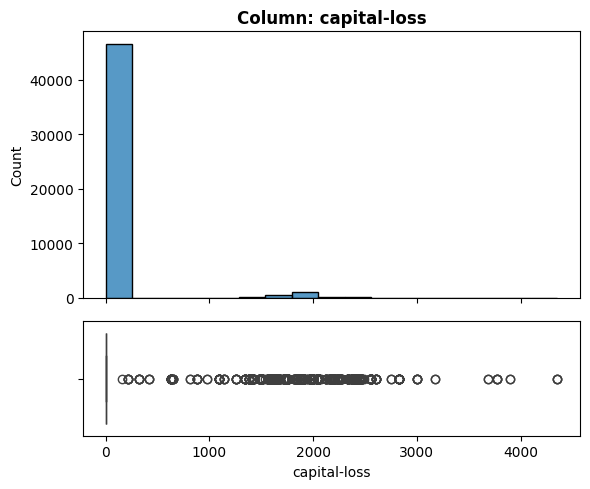

- NaN's Found: 0 (0.0%)
- Unique Values: 99
- Most common value: '0' occurs 46508 times (95.32%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: capital-loss'}, xlabel='capital-loss', ylabel='Count'>,
        <Axes: xlabel='capital-loss'>], dtype=object))

In [142]:
feature='capital-loss'
explore_numeric(df,feature)

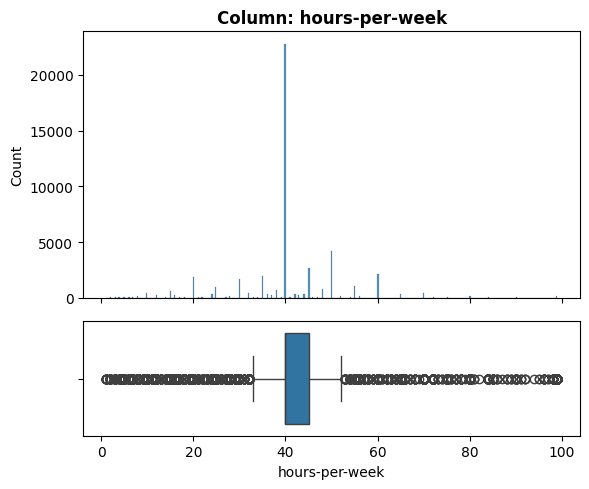

- NaN's Found: 0 (0.0%)
- Unique Values: 96
- Most common value: '40' occurs 22773 times (46.68%)
- Not constant or quasi-constant.


(<Figure size 600x500 with 2 Axes>,
 array([<Axes: title={'center': 'Column: hours-per-week'}, xlabel='hours-per-week', ylabel='Count'>,
        <Axes: xlabel='hours-per-week'>], dtype=object))

In [143]:
feature='hours-per-week'
explore_numeric(df,feature)

/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


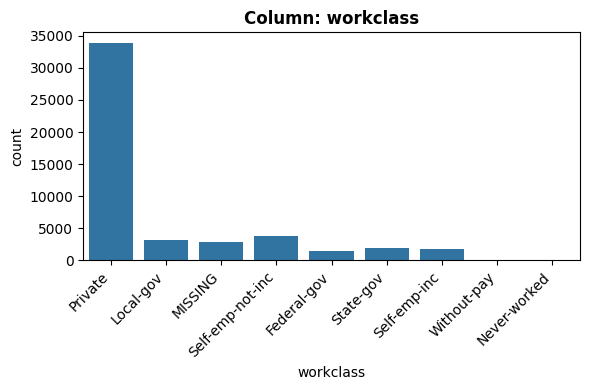

- NaN's Found: 2795 (5.73%)
- Unique Values: 9
- Most common value: 'Private' occurs 33860 times (69.4%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: workclass'}, xlabel='workclass', ylabel='count'>)

In [144]:
feature='workclass'
explore_categorical(df,feature)

/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


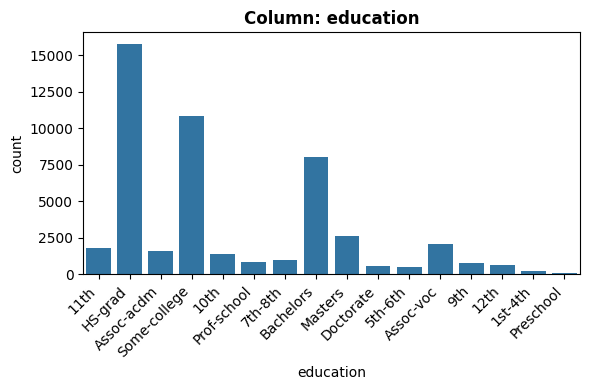

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'HS-grad' occurs 15770 times (32.32%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: education'}, xlabel='education', ylabel='count'>)

In [145]:
feature='education'
explore_categorical(df,feature)

/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


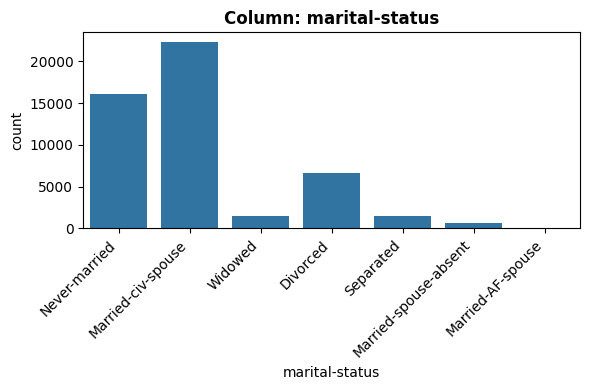

- NaN's Found: 0 (0.0%)
- Unique Values: 7
- Most common value: 'Married-civ-spouse' occurs 22366 times (45.84%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: marital-status'}, xlabel='marital-status', ylabel='count'>)

In [146]:
feature='marital-status'
explore_categorical(df,feature)

/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


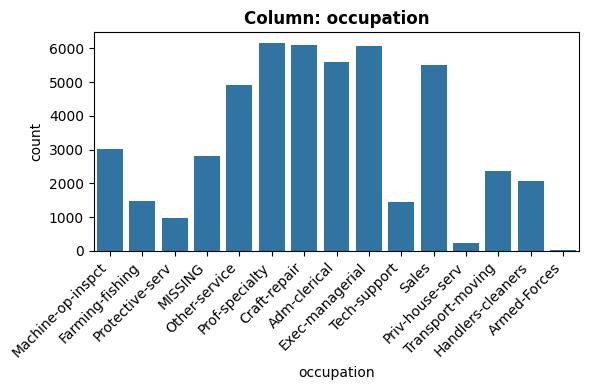

- NaN's Found: 2805 (5.75%)
- Unique Values: 15
- Most common value: 'Prof-specialty' occurs 6165 times (12.64%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: occupation'}, xlabel='occupation', ylabel='count'>)

In [147]:
feature='occupation'
explore_categorical(df,feature)

/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


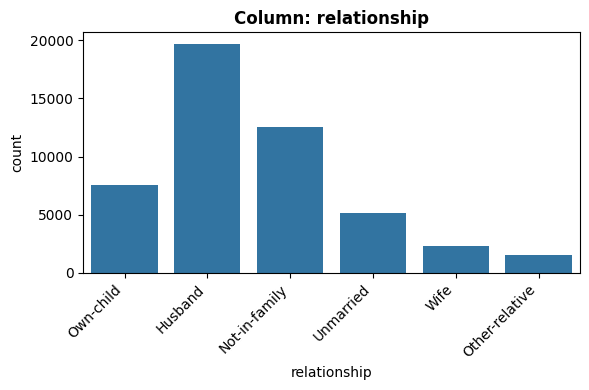

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: 'Husband' occurs 19703 times (40.38%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: relationship'}, xlabel='relationship', ylabel='count'>)

In [148]:
feature='relationship'
explore_categorical(df,feature)

/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


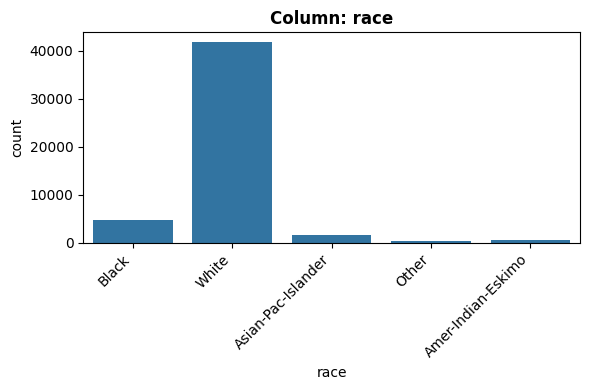

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'White' occurs 41714 times (85.5%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: race'}, xlabel='race', ylabel='count'>)

In [149]:
feature='race'
explore_categorical(df,feature)

/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


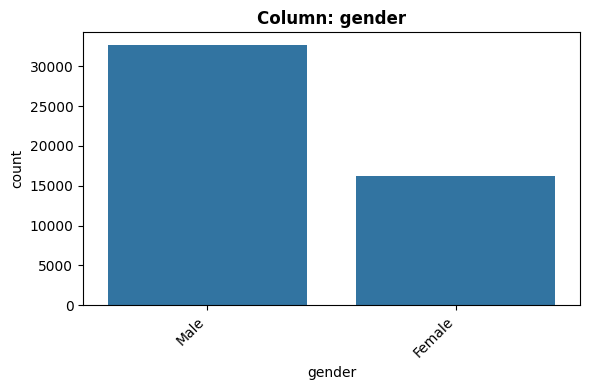

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Male' occurs 32614 times (66.85%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: gender'}, xlabel='gender', ylabel='count'>)

In [150]:
feature='gender'
explore_categorical(df,feature)

/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


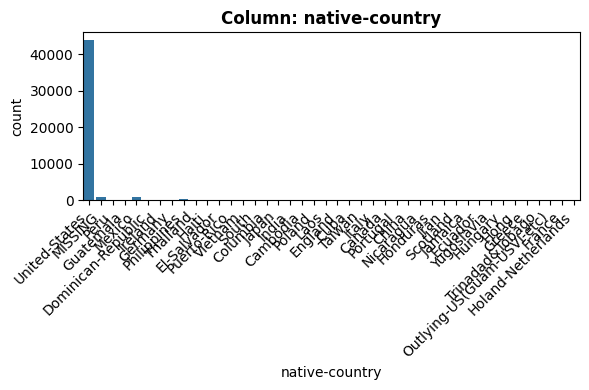

- NaN's Found: 856 (1.75%)
- Unique Values: 42
- Most common value: 'United-States' occurs 43792 times (89.76%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: native-country'}, xlabel='native-country', ylabel='count'>)

In [151]:
feature='native-country'
explore_categorical(df,feature)

/tmp/ipython-input-1613442045.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


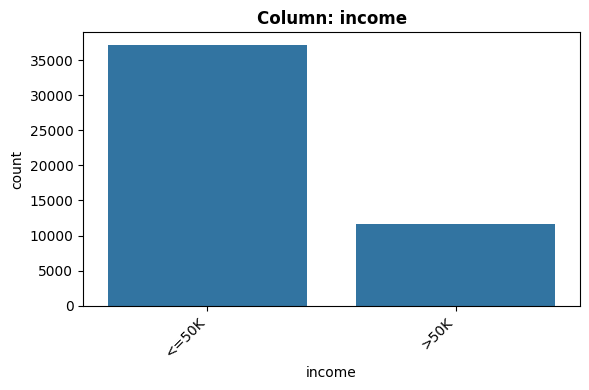

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '<=50K' occurs 37109 times (76.06%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: income'}, xlabel='income', ylabel='count'>)

In [152]:
feature='income'
explore_categorical(df,feature)

#preprocessor for ML

In [153]:

X = df.drop(columns='income')
y=df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
38093,82,NaN,Assoc-voc,11,Widowed,NaN,Not-in-family,White,Female,0,0,8,United-States
43391,30,State-gov,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,50,United-States
3064,28,Private,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,3137,0,45,United-States
45606,20,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,15,France
2116,39,Private,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States


In [154]:
# i decided to impute by median because median is not influenced by extreme values.
num_cols = X_train.select_dtypes('number').columns

num_imputer = SimpleImputer(strategy='median')

num_scaler = StandardScaler()

num_pipe = make_pipeline(num_imputer, num_scaler)
num_tuple = ('numaric', num_pipe, num_cols)
num_tuple

('numaric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
        'hours-per-week'],
       dtype='object'))

In [155]:
# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='most_frequent')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

OneHotEncoder Columns: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')


('categorical',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['workclass', 'education', 'marital-status', 'occupation',
        'relationship', 'race', 'gender', 'native-country'],
       dtype='object'))

In [156]:
#Creat prerocessor
preprocessor = ColumnTransformer(transformers=[num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numaric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [157]:
from sklearn.ensemble import RandomForestClassifier

RandomF_defult = RandomForestClassifier(random_state=42)
RandomF_defult_pipe = make_pipeline(preprocessor, RandomF_defult)
RandomF_defult_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numaric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [159]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict


In [160]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.98      0.99      0.98     27841
        >50K       0.96      0.93      0.94      8751

    accuracy                           0.97     36592
   macro avg       0.97      0.96      0.96     36592
weighted avg       0.97      0.97      0.97     36592



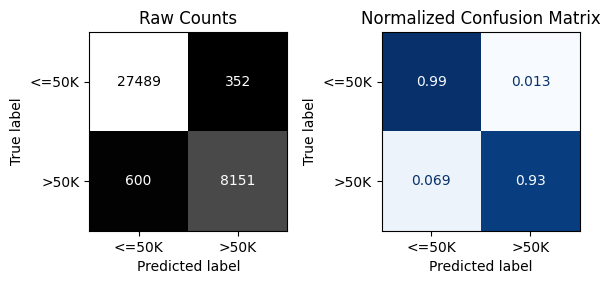


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.89      0.92      0.90      9268
        >50K       0.70      0.63      0.66      2930

    accuracy                           0.85     12198
   macro avg       0.80      0.77      0.78     12198
weighted avg       0.84      0.85      0.84     12198



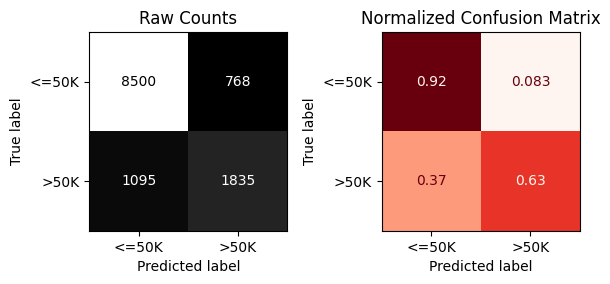

In [161]:
#evaluate RF model
evaluate_classification(RandomF_defult_pipe, X_train, y_train, X_test, y_test)

In [162]:
from sklearn.inspection import permutation_importance
SEED = 42
r = permutation_importance(RandomF_defult_pipe, X_train, y_train ,n_repeats =5, random_state = SEED)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [163]:
## can make the mean importances into a series
feature_names = X_train.columns
perm_importances = pd.Series(r['importances_mean'],index=feature_names,
                           name = 'permutation importance')
perm_importances.head()

,permutation importance
age,0.104291
workclass,0.056471
education,0.063681
educational-num,0.043414
marital-status,0.070157


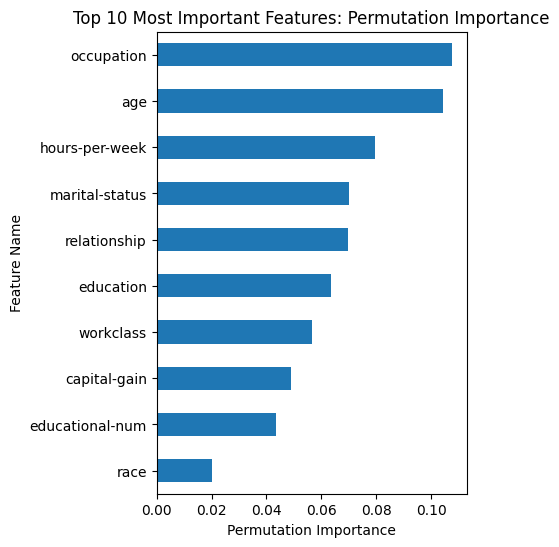

In [123]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');

In [164]:
kmeans = KMeans (n_clusters=4, n_init = 'auto', random_state=42)

kmeans_pipe = make_pipeline(preprocessor, kmeans)
kmeans_pipe.fit(X_train, y_train)

# Apply preprocessing to X_train and X_test before adding cluster labels
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#create clusters using kmeans
y_train_pred_clusters = kmeans.predict(X_train_processed)
y_test_pred_clusters = kmeans.predict(X_test_processed)

# Add cluster labels to the processed training and test data
X_train_clustered = X_train_processed.copy()
X_test_clustered = X_test_processed.copy()

X_train_clustered['cluster'] = y_train_pred_clusters
X_test_clustered['cluster'] = y_test_pred_clusters

In [125]:
#create clusters using kmeans
y_train_pred = kmeans_pipe.predict(X_train)
y_test_pred = kmeans_pipe.predict(X_test)

In [126]:
# Add cluster labels to the training and test data
X_train_clustered = X_train.copy()
X_test_clustered = X_test.copy()

X_train_clustered['cluster'] = y_train_pred
X_test_clustered['cluster'] = y_test_pred


In [127]:
print(X_train_clustered['cluster'].value_counts())


cluster
0    14279
1    11800
2     8836
3     1677
Name: count, dtype: int64


In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_clustered, y_train)

y_pred = rf.predict(X_test_clustered)
print("Accuracy:", accuracy_score(y_test, y_pred))

ValueError: could not convert string to float: 'State-gov'

#Feature enginering

In [ ]:
#combine capital gain and capital loss columns
df['capital']=df['capital-gain']-df['capital-loss']
df['capital']
#drop capital gain and capital loss
df=df.drop(columns=['capital-gain','capital-loss'])
df.head()

In [166]:
from sklearn.feature_selection import VarianceThreshold

# Apply the preprocessor to the training data before fitting VarianceThreshold
X_train_processed = preprocessor.transform(X_train)

# Initialize and fit VarianceThreshold on the processed data
selector = VarianceThreshold(threshold=0.05)
selector.fit(X_train_processed)

VarianceThreshold(threshold=0.05)

In [168]:
keep_ft=selector.get_support()
keep_ft

array([ True,  True,  True,  True,  True, False,  True, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True,  True, False,
       False,  True,  True, False,  True, False,  True, False, False,
        True, False,  True,  True, False, False,  True,  True, False,
        True, False,  True, False, False,  True,  True, False,  True,
        True, False, False, False,  True, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False])

In [169]:
keep_ft.sum()

np.int64(31)

In [173]:
X_train_var=X_train_processed.loc[:,keep_ft]
X_test_var=X_test_processed.loc[:,keep_ft]

In [174]:
# Train a RandomForestClassifier on the variance-threshold-selected features
rf_var = RandomForestClassifier(random_state=42)
rf_var.fit(X_train_var, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#evaluate


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.98      0.99      0.98     27841
        >50K       0.95      0.92      0.94      8751

    accuracy                           0.97     36592
   macro avg       0.96      0.95      0.96     36592
weighted avg       0.97      0.97      0.97     36592



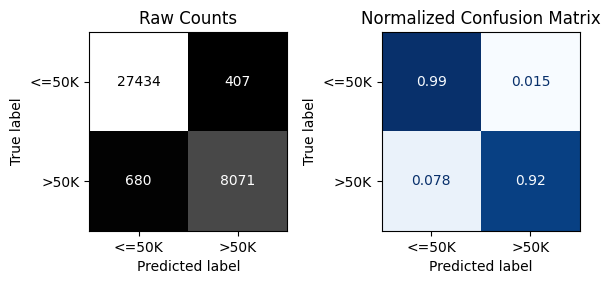


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      9268
        >50K       0.71      0.62      0.66      2930

    accuracy                           0.85     12198
   macro avg       0.80      0.77      0.78     12198
weighted avg       0.84      0.85      0.84     12198



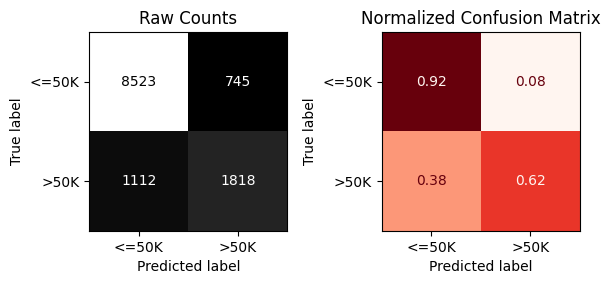

In [175]:
# Evaluate the model trained on variance-threshold-selected features
evaluate_classification(rf_var, X_train_var, y_train, X_test_var, y_test)